In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
%matplotlib inline


In [2]:
import matplotlib.pyplot as plt
# Data data = [
    (93, '░', 5), (2, '░', 5), (8, '░', 0), (39, '█', 1), (64, '░', 0), (63, '█', 1), (84, '█', 3), (9, '█', 4),
    #... (other data points) ...(83, '█', 2), (27, '█', 1), (61, '█', 3), (28, '░', 4), (14, '█', 1), (42, '█', 6)]
# Extracting values x_values = [item[0] for item in data]symbols = [item[1] for item in data]y_values = [item[2] for item in data]
# Creating the plot plt.figure(figsize=(10, 6))
for i, symbol in enumerate(symbols):
    if symbol == '█':
        plt.scatter(x_values[i], y_values[i], color='blue', label=symbol)
    else:
        plt.scatter(x_values[i], y_values[i], color='red', label=symbol)
# Adding labels and title plt.xlabel('X Values')plt.ylabel('Y Values')plt.title('Scatter Plot of Data')plt.legend(['█', '░'])
# Show plot plt.show()

IndentationError: unexpected indent (2792209510.py, line 3)

<class 'pandas.core.frame.DataFrame'>
Index: 371 entries, 0 to 371
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Home    371 non-null    float64
 1   Draw    371 non-null    float64
 2   Away    371 non-null    float64
 3   Result  371 non-null    int64  
dtypes: float64(3), int64(1)
memory usage: 14.5 KB


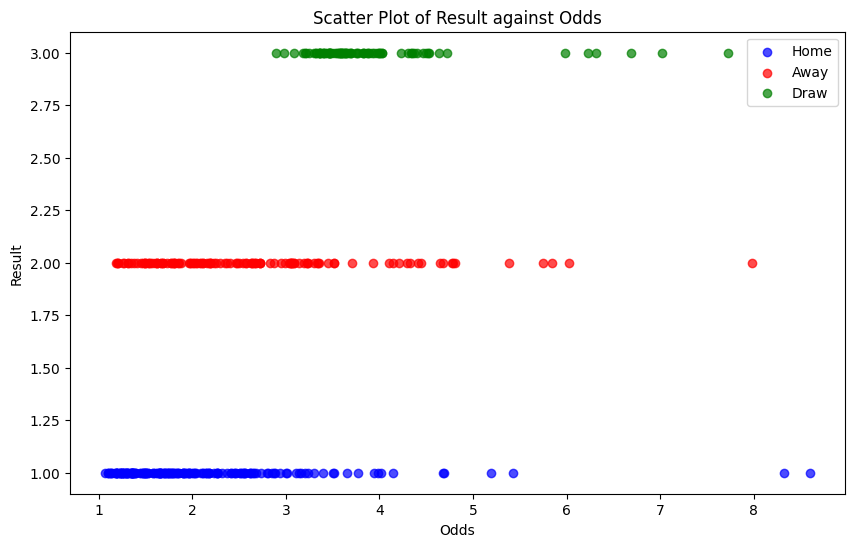

In [3]:
data = pd.read_csv("odds_analysis.csv")
data = data[data['Away'] < 40]
data.info()

# Create a scatter plot based on the conditions
plt.figure(figsize=(10, 6))

# Plotting home_odds for Result equal to 1
plt.scatter(data[data['Result'] == 1]['Home'],data[data['Result'] == 1]['Result'], color='blue', label='Home', alpha=0.7)

# Plotting away_odds for Result equal to 2
plt.scatter(data[data['Result'] == 2]['Away'],data[data['Result'] == 2]['Result'],  color='red', label='Away', alpha=0.7)

# Plotting draw_odds for Result equal to 3
plt.scatter(data[data['Result'] == 3]['Draw'],data[data['Result'] == 3]['Result'],  color='green', label='Draw', alpha=0.7)

plt.title('Scatter Plot of Result against Odds')
plt.xlabel('Odds')
plt.ylabel('Result')
plt.legend()
plt.show()

In [ ]:
# Create a DataFrame to calculate the average odds for each result
result_avg_odds = data.groupby('Result')[['Home', 'Away', 'Draw']].mean()


# Create a heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(result_avg_odds, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Average Odds for Each Result')
plt.xlabel('Odds Type')
plt.ylabel('Result')
plt.show()

In [ ]:
# Create a count plot for each result
plt.figure(figsize=(8, 6))
sns.set(style="whitegrid")
ax = sns.countplot(x='Result', data=data, palette='Set2')

# Display count numbers on top of each bar
for p in ax.patches:
    ax.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='baseline')

plt.title('Count Plot of Results')
plt.xlabel('Result')
plt.ylabel('Count')
plt.show()

In [ ]:
# Define features (odds) and target variable (result)
X = data[['Home', 'Away', 'Draw']]
y = data['Result']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=190)


# Create and train a logistic regression,KNeighborsClassifier and RandomForestClassifier models
# model = RandomForestClassifier(n_estimators=20) Very poor 
model = LogisticRegression(C=10)
# model = KNeighborsClassifier(n_neighbors=20) Poor
model.fit(X_train, y_train)

# Make predictions on the test set
test_odds = [[3.28,3.38,2.3]]
predictions = model.predict(X_test)
test_pred = model.predict(test_odds)

# Evaluate the model
cross_val_accuracy = cross_val_score(model, X, y, cv=10, scoring='accuracy')
conf_matrix = confusion_matrix(y_test, predictions)
class_report = classification_report(y_test, predictions)
print(test_pred)
print(f'Cross-Validation Accuracy: {cross_val_accuracy.mean()}')
print(conf_matrix)
print(f'Classification Report: {class_report}')




In [ ]:
# Identify the minimum odds among 'Home', 'Away', and 'Draw'
data['min_odd'] = data[['Home', 'Away', 'Draw']].min(axis=1)

# Count the occurrences of each result for the minimum odds
result_counts = data.groupby('min_odd')['Result'].value_counts().fillna(0)

# print(result_counts)




In [ ]:
# Train SVM
model = SVC()
model.fit(X_train, y_train)
predictions = model.predict(X_test)


# Make predictions on the test set
test_odds = [[3.28,3.38,2.3]]
test_pred = model.predict(test_odds)

# Evaluate the model
cross_val_accuracy = cross_val_score(model, X, y, cv=10, scoring='accuracy')
conf_matrix = confusion_matrix(y_test, predictions)
class_report = classification_report(y_test, predictions)
print(test_pred)
print(f'Cross-Validation Accuracy: {cross_val_accuracy.mean()}')
print(conf_matrix)
print(class_report)




In [ ]:
from sklearn.model_selection import GridSearchCV

# Implement GridSearch
param_grid = {"C": [0.1,1,10,100], "gamma": [1,0.1,0.01,0.001]}
grid = GridSearchCV(SVC(), param_grid, verbose=3)
grid.fit(X_train, y_train)



In [ ]:
grid_prediction = grid.predict(X_test)
conf_matrix = confusion_matrix(y_test, grid_prediction)
print(conf_matrix)
class_report = classification_report(y_test, grid_prediction)
print(f'Cross-Validation Accuracy: {cross_val_accuracy.mean()}')
print(classification_report(y_test, grid_prediction))